# Clustering

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
from math import pi
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

import warnings
warnings.filterwarnings("ignore")
color = "#6200EE"
edgecolor= "#03DAC5"

## New Feautures

Preparazione dataset per generazione dei nuovi attributi da usare nel clusterin

**Creazione delle features per il clustering**

In [220]:
df = pd.read_csv('../../data/cluster.csv').reset_index(names='id')
df['date'] = pd.to_datetime(df['date'])    
df = df[df.n_participants > 0]

df['n_participants_child_ratio'] = df['n_participants_child'] / df['n_participants']
df['n_participants_teen_ratio'] = df['n_participants_teen'] / df['n_participants']
df['n_participants_adult_ratio'] = df['n_participants_adult'] / df['n_participants']

df['n_males_ratio'] = df['n_males']/df['n_participants']
df['n_females_ratio'] = df['n_females']/df['n_participants']

df['n_arrested_ratio'] = df['n_arrested']/df['n_participants']
df['n_unharmed_ratio'] = df['n_unharmed']/df['n_participants']
df['n_injured_ratio'] = df['n_injured']/df['n_participants']
df['n_killed_ratio'] = df['n_killed']/df['n_participants']

df['poverty_ratio'] = df['povertyPercentage']/100

df['incident_severity'] = (df['n_killed_ratio'] + df['n_injured_ratio'])/df['n_participants']

selected_columns = ['latitude', 'longitude', 'n_participants_child', 'n_participants_teen', 'n_participants_adult', 'avg_age_participants',
                    'n_males', 'n_females', 'n_killed', 'n_arrested', 'n_unharmed', 'n_injured', 'n_participants', 'povertyPercentage',
                    "n_participants_child_ratio","n_participants_teen_ratio","n_participants_adult_ratio","n_males_ratio","n_females_ratio",
                   "n_arrested_ratio","n_unharmed_ratio","n_injured_ratio","n_killed_ratio","poverty_ratio", "incident_severity"]
df_illinois=df[(df["state"]== "Illinois")]
df = df[selected_columns]
finalAttr={'n_males', 'n_females', 'poverty_ratio', 'incident_severity', 'n_participants', 'avg_age_participants'}

**Calcolo matrice di correlazione** (ci aiuta a scegliere quali attributi mantenere)

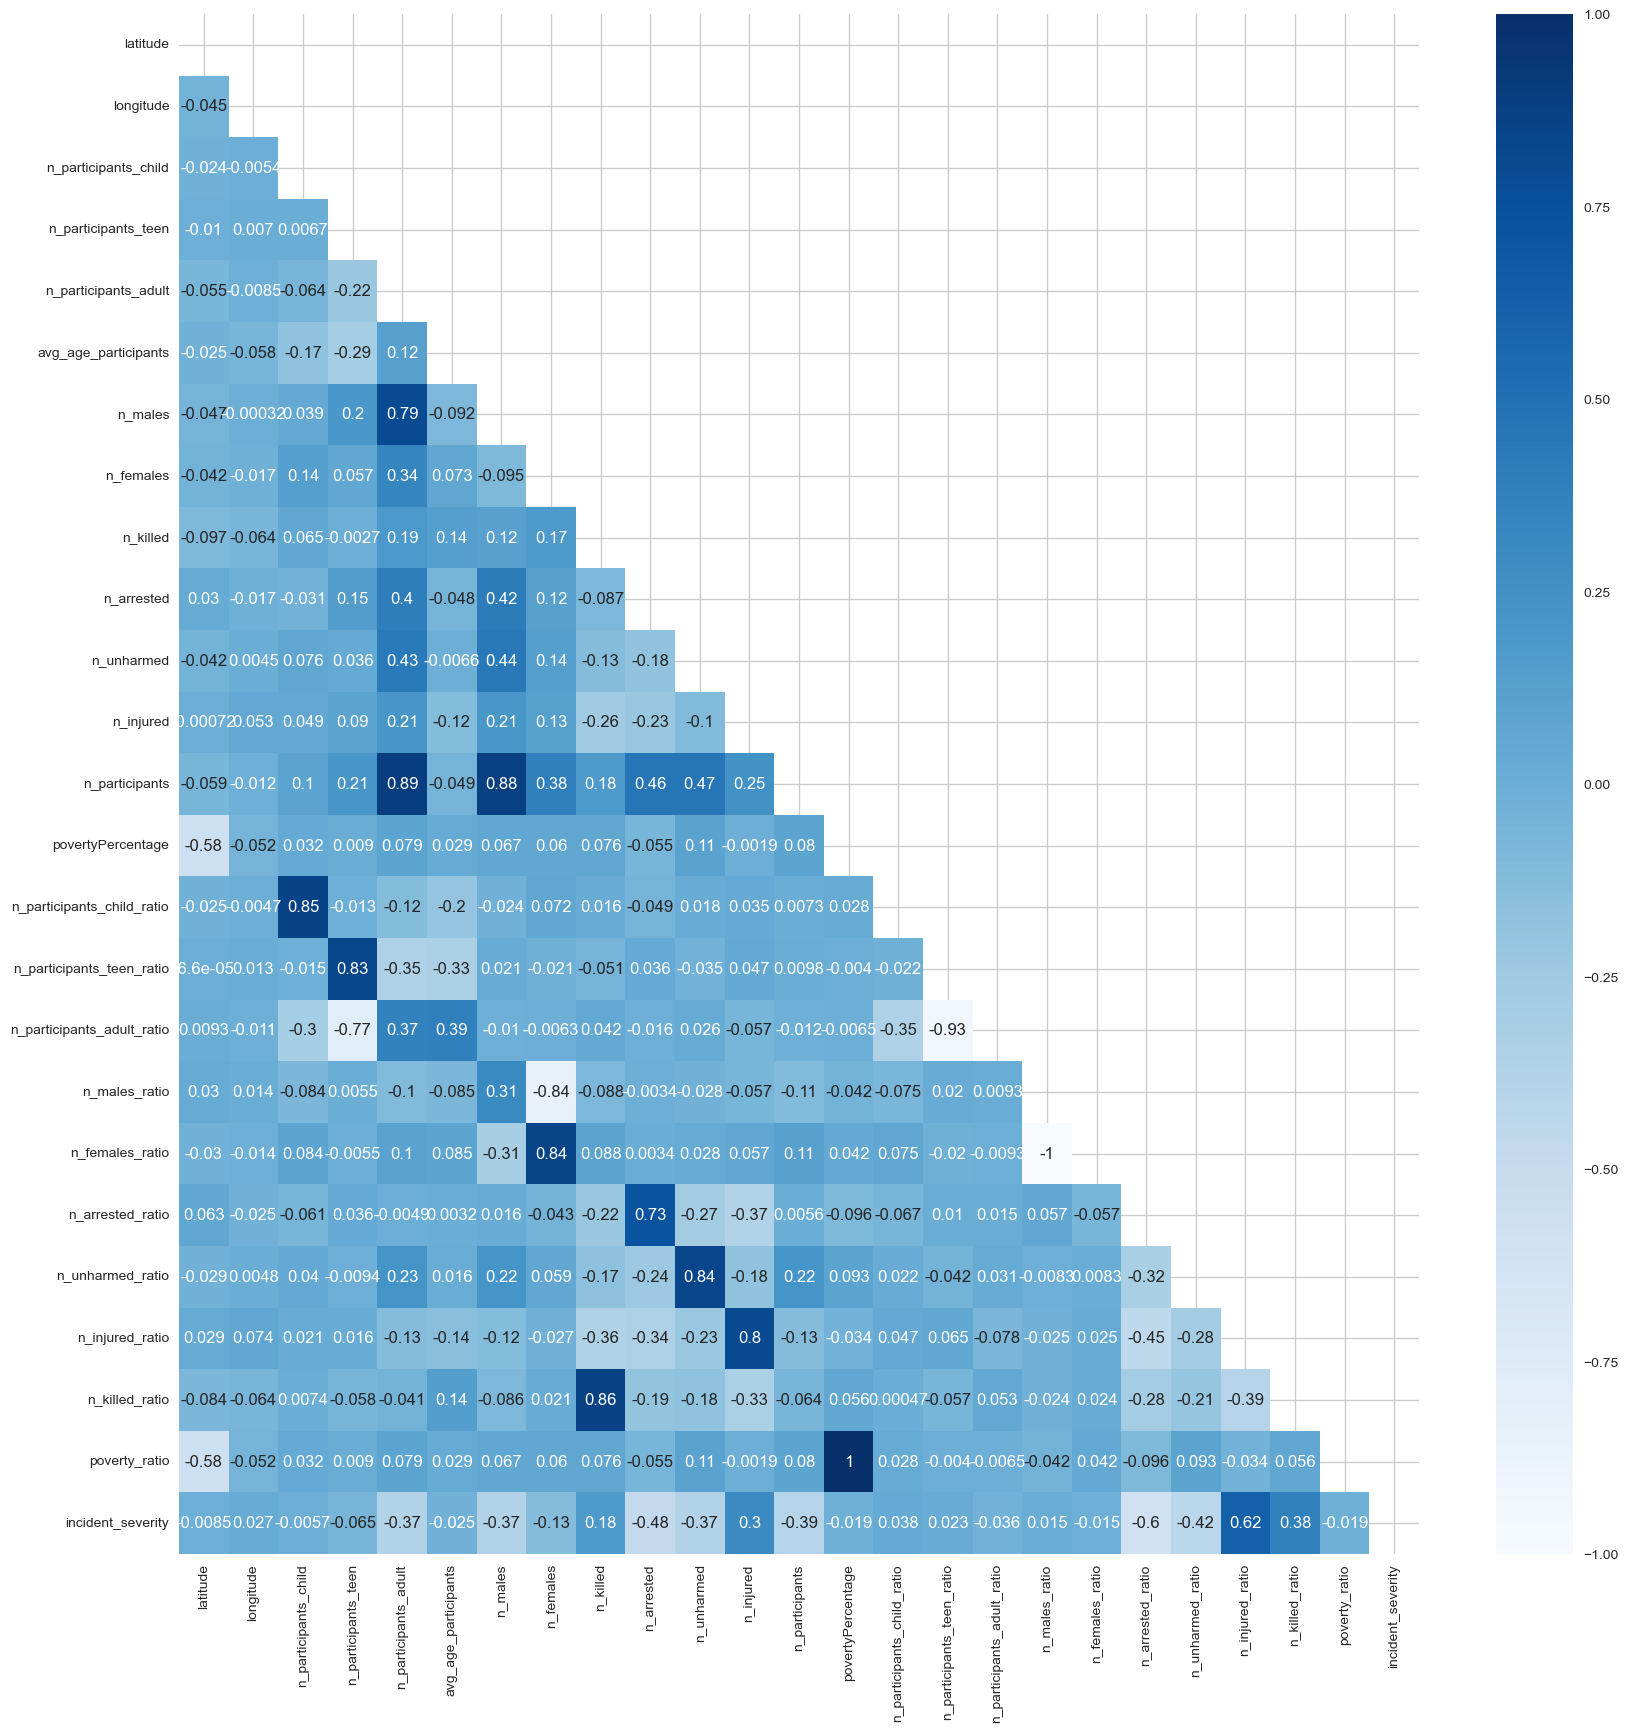

In [46]:
data = df.corr()
mask = np.triu(np.ones_like(data, dtype=bool))

plt.figure(figsize=(20,20))
sns.heatmap(data, annot=True, cmap='Blues', mask=mask)
plt.show()

**Testiamo diverse combinazioni di features per il clustering**

In [221]:
selected_columns= ['n_males_ratio', 'n_females_ratio', 'poverty_ratio', 'incident_severity', 'n_participants', 'avg_age_participants']
Fdf=df[finalAttr].dropna()
df=df[selected_columns].dropna()

A seguito di alcuni test, che non saranno riportati nel notebook definitivo teniamo come attributi quelli presenti in **selected_columns**, l'obbiettivo potrebbe essere quello di trovare una divisione in cluster che separi incidenti con prevalenza di uomini coinvolti dal resto

### Breve analisi del dataset **df_illinois** per cercare qualche pattern interessante specifico per lo stato scelto

<Axes: >

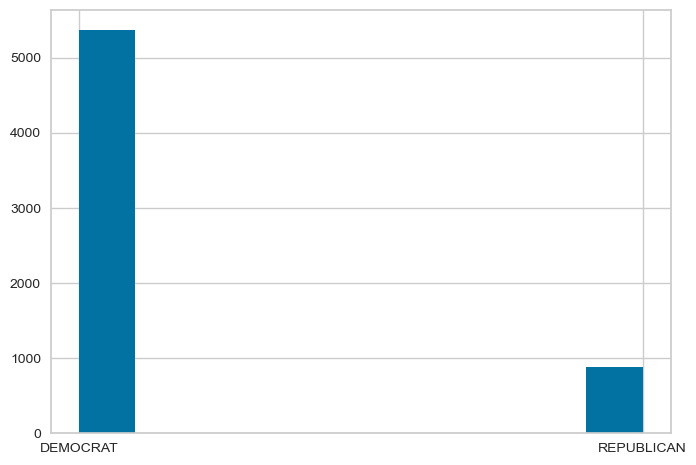

In [48]:
#plottarre la distribuzione degli incidenti in base al partito vincente nello stato di ILLINOIS
df_illinois["party"].hist()

In [49]:
df_illinois["povertyPercentage"].value_counts()

10.9    3630
10.4    3072
11.3    2487
12.2    2227
9.2      472
Name: povertyPercentage, dtype: int64

#### Dalla distribuzione del numero d'incidenti rispetto la povertà dello stato, non sembra esserci correlazione

                  winner_dominance     count
winner_dominance          1.000000  0.322494
count                     0.322494  1.000000


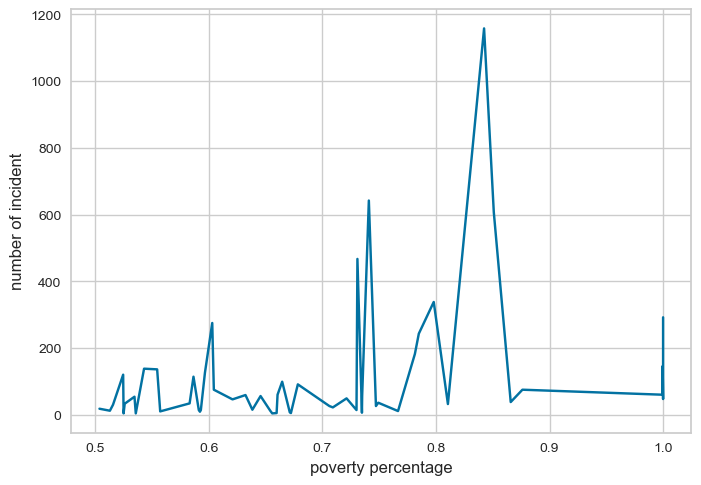

In [222]:
#plottare ad esempio la distribuzione di winnerdominance rispetto al numero di incidenti avvenuti
#la winner dominance è relativa ad un distretto in uno specifico anno, la distribuzione va fatta rispettando le specifiche
df_illinois["winner_dominance"]= df_illinois["candidatevotes"]/df_illinois["totalvotes"]
#non basta quindi contare il numero di incidenti con la stessa dominance perchè nello stesso gruppo vanno quelli con
#stessa stessa dominace, distretto e anno
temp=df_illinois[["congressional_district","winner_dominance","date"]].dropna()
temp["year"]=temp["date"].dt.year
temp=temp.drop(columns= ["date"])
temp["count"]=0
temp=temp.groupby(["congressional_district", "year","winner_dominance"],as_index=False)["count"].count()
#corerlazione tra winner dominance e count ?
print(temp[["winner_dominance","count"]].corr())
temp=temp[["winner_dominance","count"]]
temp.sort_values(by=["winner_dominance"],inplace=True)
fig, ax = plt.subplots()
ax.plot(temp["winner_dominance"],temp["count"])
ax.set_xlabel("poverty percentage")
ax.set_ylabel("number of incident")

#adesso posso droppare gli attributi
Fdf_illinois=df_illinois[finalAttr].dropna()
df_illinois=df_illinois[selected_columns].dropna()

#### Non sembra esserci correlazione tra basso consenso dei voti del partito vincente in un distretto ed un aumento nel numero di incidenti nei diversi congressi ed anni

### Clustering Preprocessing - Normalization  
A good practice in clustering to avoid the bias given by the range of the different attribute is normalization.  
The most common adopted normalizations are: Z-Score and Min-Max
* Uso Z-Score perchè k-means è sensibile agli outliers e con questa normalizza

In [63]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_normalized=scaler.fit_transform(df)
df_normIllinois=.scaler.fit_transform(df_illinois)

## K-means

Si utilizza l'**elbow method** per stabilire il miglior valore per k

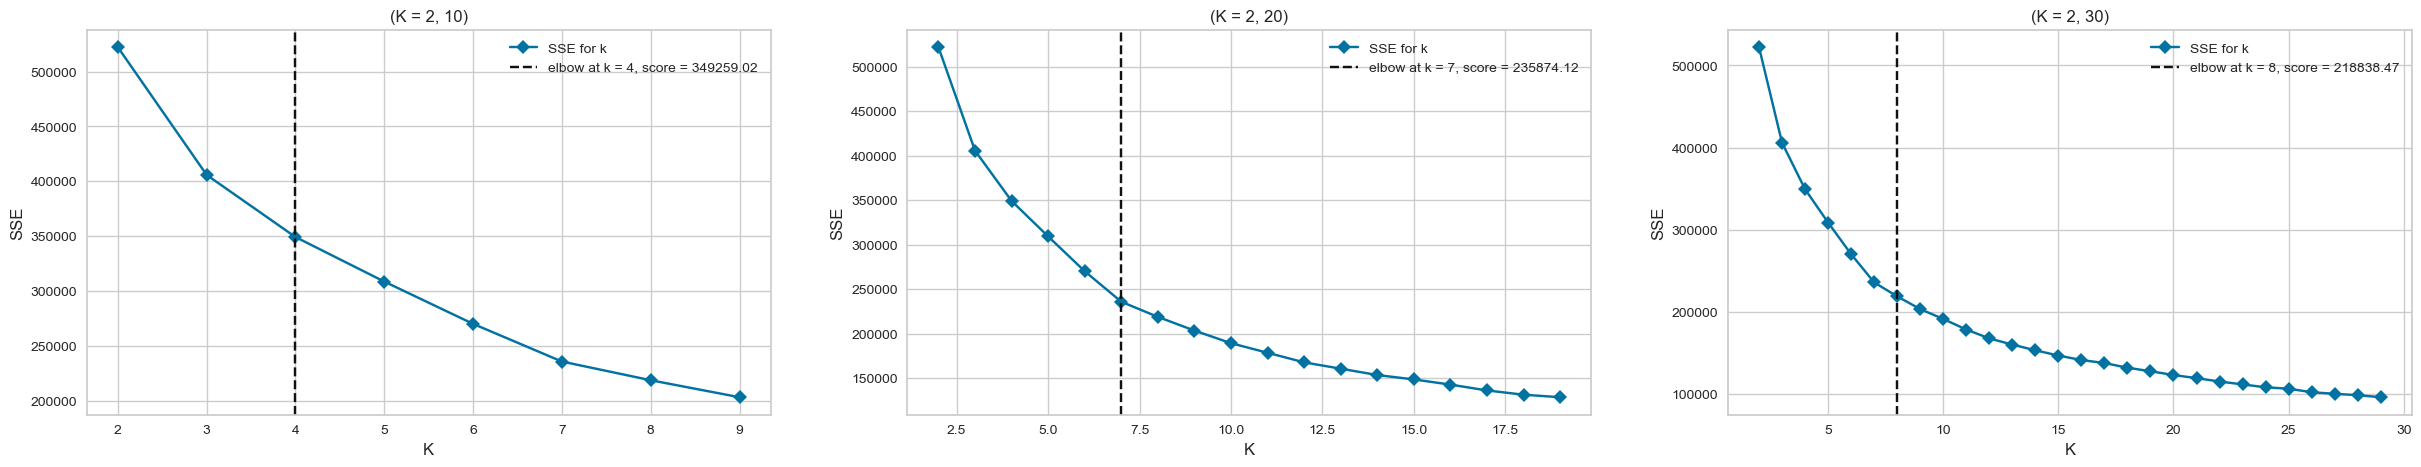

In [15]:
from yellowbrick.cluster import KElbowVisualizer

k_start = [2]
k_max = [10, 20,30]
Ks = []
model = KMeans()

f, axs = plt.subplots(nrows=1, ncols=len(k_max), figsize=(30,5))

for i in range(len(k_max)):
    vis = KElbowVisualizer(model, k=(k_start[0],k_max[i]), metric='distortion', timings=False, ax=axs[i])
    vis.fit(df_normalized)  
    axs[i].set_title('(K = ' + str(k_start[0]) + ', ' + str(k_max[i]) + ')' )
    axs[i].set_ylabel('SSE')
    axs[i].set_xlabel('K')
    axs[i].legend(['SSE for k','elbow at k = ' + str(vis.elbow_value_) + ', score = ' + '{:.2f}'.format(vis.elbow_score_)])
    if (vis.elbow_value_ not in Ks) and (vis.elbow_value_ != None):
        Ks.append(vis.elbow_value_)
plt.show()

I migliori valori sembrerebbero essere 4, 7 e 8. <br> Utilizzaimo questi valori per calcolare **sihouette_score** (separation measure) e **davies_bouldin_score** così da stabilire il miglior valore di k.

### Silhouette Score e davies_bouldin_score

In [57]:
k_values =[4, 7, 8]
kmeans = KMeans()
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_normalized)
    sil= silhouette_score(df_normalized, kmeans.labels_)
    dav= davies_bouldin_score(df_normalized, kmeans.labels_)
    print(f"K = {k}, silhouette_score = {sil}, davies_bouldin_score = {dav}")


K = 4, silhouette_score = 0.3245702824917721, davies_bouldin_score = 1.2880362474060285
K = 7, silhouette_score = 0.3386330646304633, davies_bouldin_score = 1.0481433207237396
K = 8, silhouette_score = 0.32199750120089604, davies_bouldin_score = 1.1063355686129372


**Considerando le tre metriche calcolate, il miglior valore per k, sembrerebbe essere 7**

### Risultati per k = 7
Rieseguendo questa cella i risultati potrebbero cambiare leggermente, nello specifico è probabile che cambi l'etichetta del cluster su cui faremo delle ipotesi, che sarà sempre presente ma con etichetta differente)

In [301]:
model = KMeans(n_clusters=7, n_init=10, max_iter=100)
model.fit(df_normalized)
centroidi = model.cluster_centers_
#inversione della normalizzazione, da adesso in poi non serve più avere valori normalizzati

for i, centroide in enumerate(centroidi):
    print(f"Centroide {i+1}: {centroide}\n")

Centroide 1: [ 0.44352333 -0.44352333 -0.25155081  1.41552734 -0.6909747  -0.32082524]

Centroide 2: [ 0.44352333 -0.44352333 -0.46663629 -0.70869575 -0.24338918 -0.31293084]

Centroide 3: [-3.53782861  3.53782861 -0.0189678   0.57511912 -0.5511034   0.07608665]

Centroide 4: [ 0.41876225 -0.41876225  1.6120776  -0.32983954  0.0679636  -0.20971891]

Centroide 5: [ 0.22311703 -0.22311703 -0.05292668 -0.72782053  2.08736348 -0.36535126]

Centroide 6: [-1.46103359  1.46103359  0.1461434  -0.45140858  0.60886045  0.20357704]

Centroide 7: [ 0.3696078  -0.3696078  -0.0253165  -0.02507222 -0.26268613  1.96672872]



Visualization of clusters centers by means of parallel coordinates

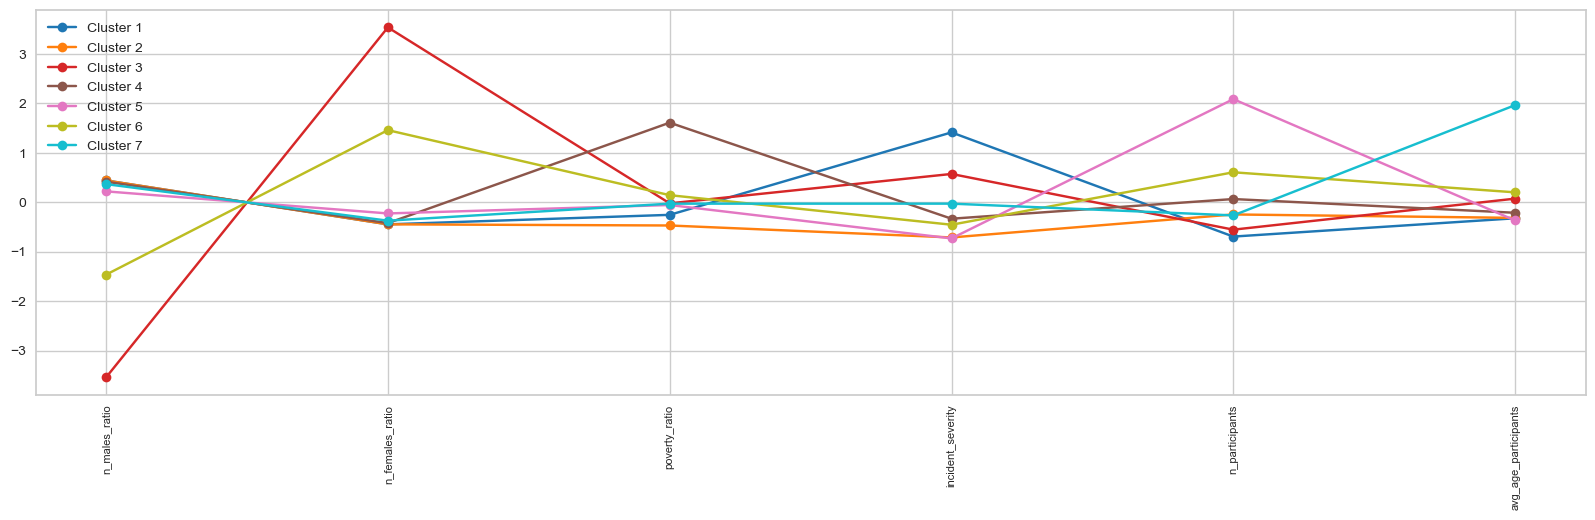

In [302]:
plt.figure(figsize=(20, 5))
colori = plt.cm.tab10(np.linspace(0, 1, 7))
for i in range(0, len(centroidi)):
    plt.plot(centroidi[i], marker='o', label='Cluster %s' % (i+1),color=colori[i])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(df.columns)), df.columns, fontsize=8, rotation='vertical')
plt.legend(fontsize=10)
plt.show()

Il cluster **3** sembrerebbe essere un cluster con incidenti con alta percentuale di donne partecipanti (i dati sono normalizzati, si rimanda ai risultati finali per conferme)

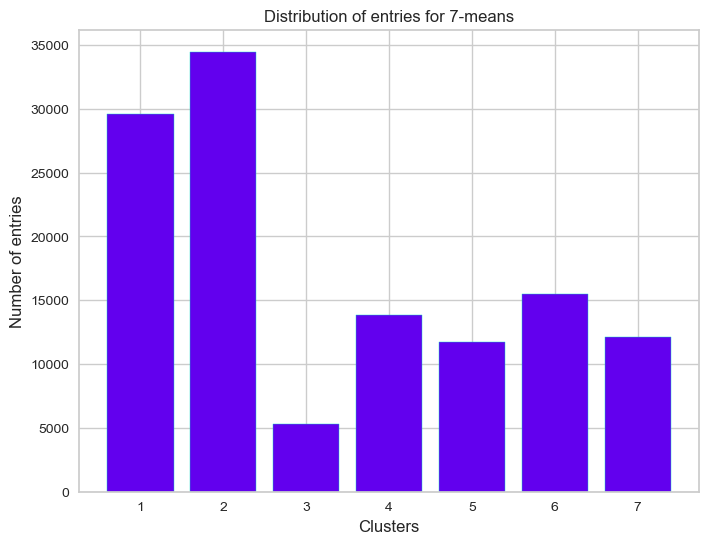

In [303]:
unique_values, value_counts = np.unique(model.labels_, return_counts=True)
plt.figure(figsize=(8, 6))  # Set the figure size (optional)
plt.bar((unique_values + 1), value_counts, color=color, edgecolor=edgecolor)

# Set labels and title
plt.xlabel('Clusters')
plt.ylabel('Number of entries')
plt.title('Distribution of entries for 7-means')
plt.show()

Come sappiamo il numero di donne coinvolte in incdenti è di molto minore rispetto al numero di uomini, perciò il fatto che il cluster 3 sia quello col minor numero di entries conferma ulteriormente la nostra supposizione

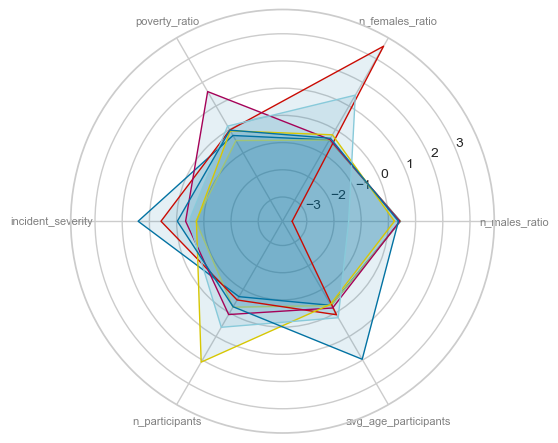

In [304]:
N = len(df.columns)
for i in range(0, len(centroidi)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centroidi[i].tolist()
    values += values[:1]
    angles += angles[:1]
    ax = plt.subplot(polar=True)
    plt.xticks(angles[:-1], df.columns, color='grey', size=8) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'b', alpha=0.1)

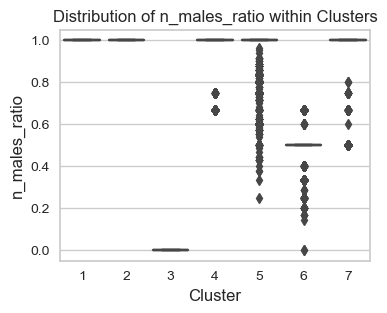

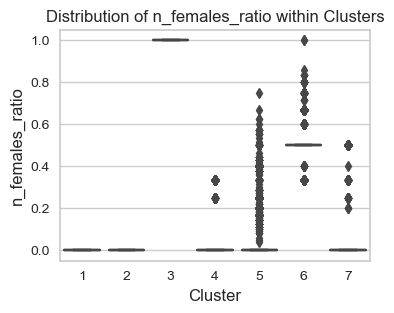

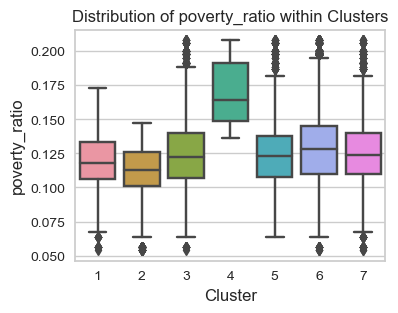

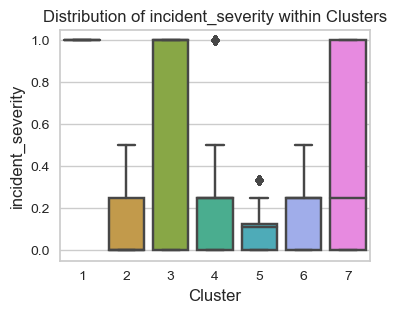

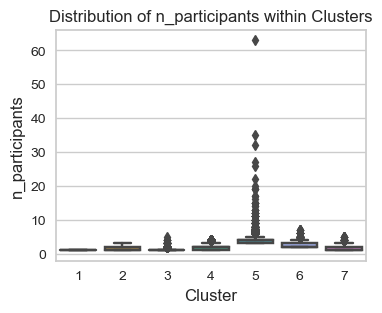

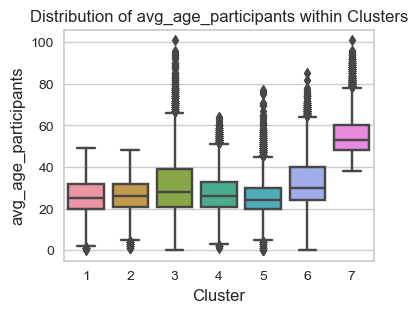

In [305]:
data = pd.DataFrame(df, columns=['n_males_ratio', 'n_females_ratio', 'poverty_ratio', 'incident_severity', 'n_participants', 'avg_age_participants'])
data['Cluster'] = model.labels_ +1

# Analyze the distribution of variables within clusters using boxplots
for variable in data.columns[:-1]: 
    plt.figure(figsize=(4, 3))
    sns.boxplot(x='Cluster', y=variable, data=data)
    plt.title(f'Distribution of {variable} within Clusters')
    plt.show()
    

### Scatter plot

In [306]:
lbls = model.labels_ +1
lbls

array([1, 7, 7, ..., 6, 1, 7])

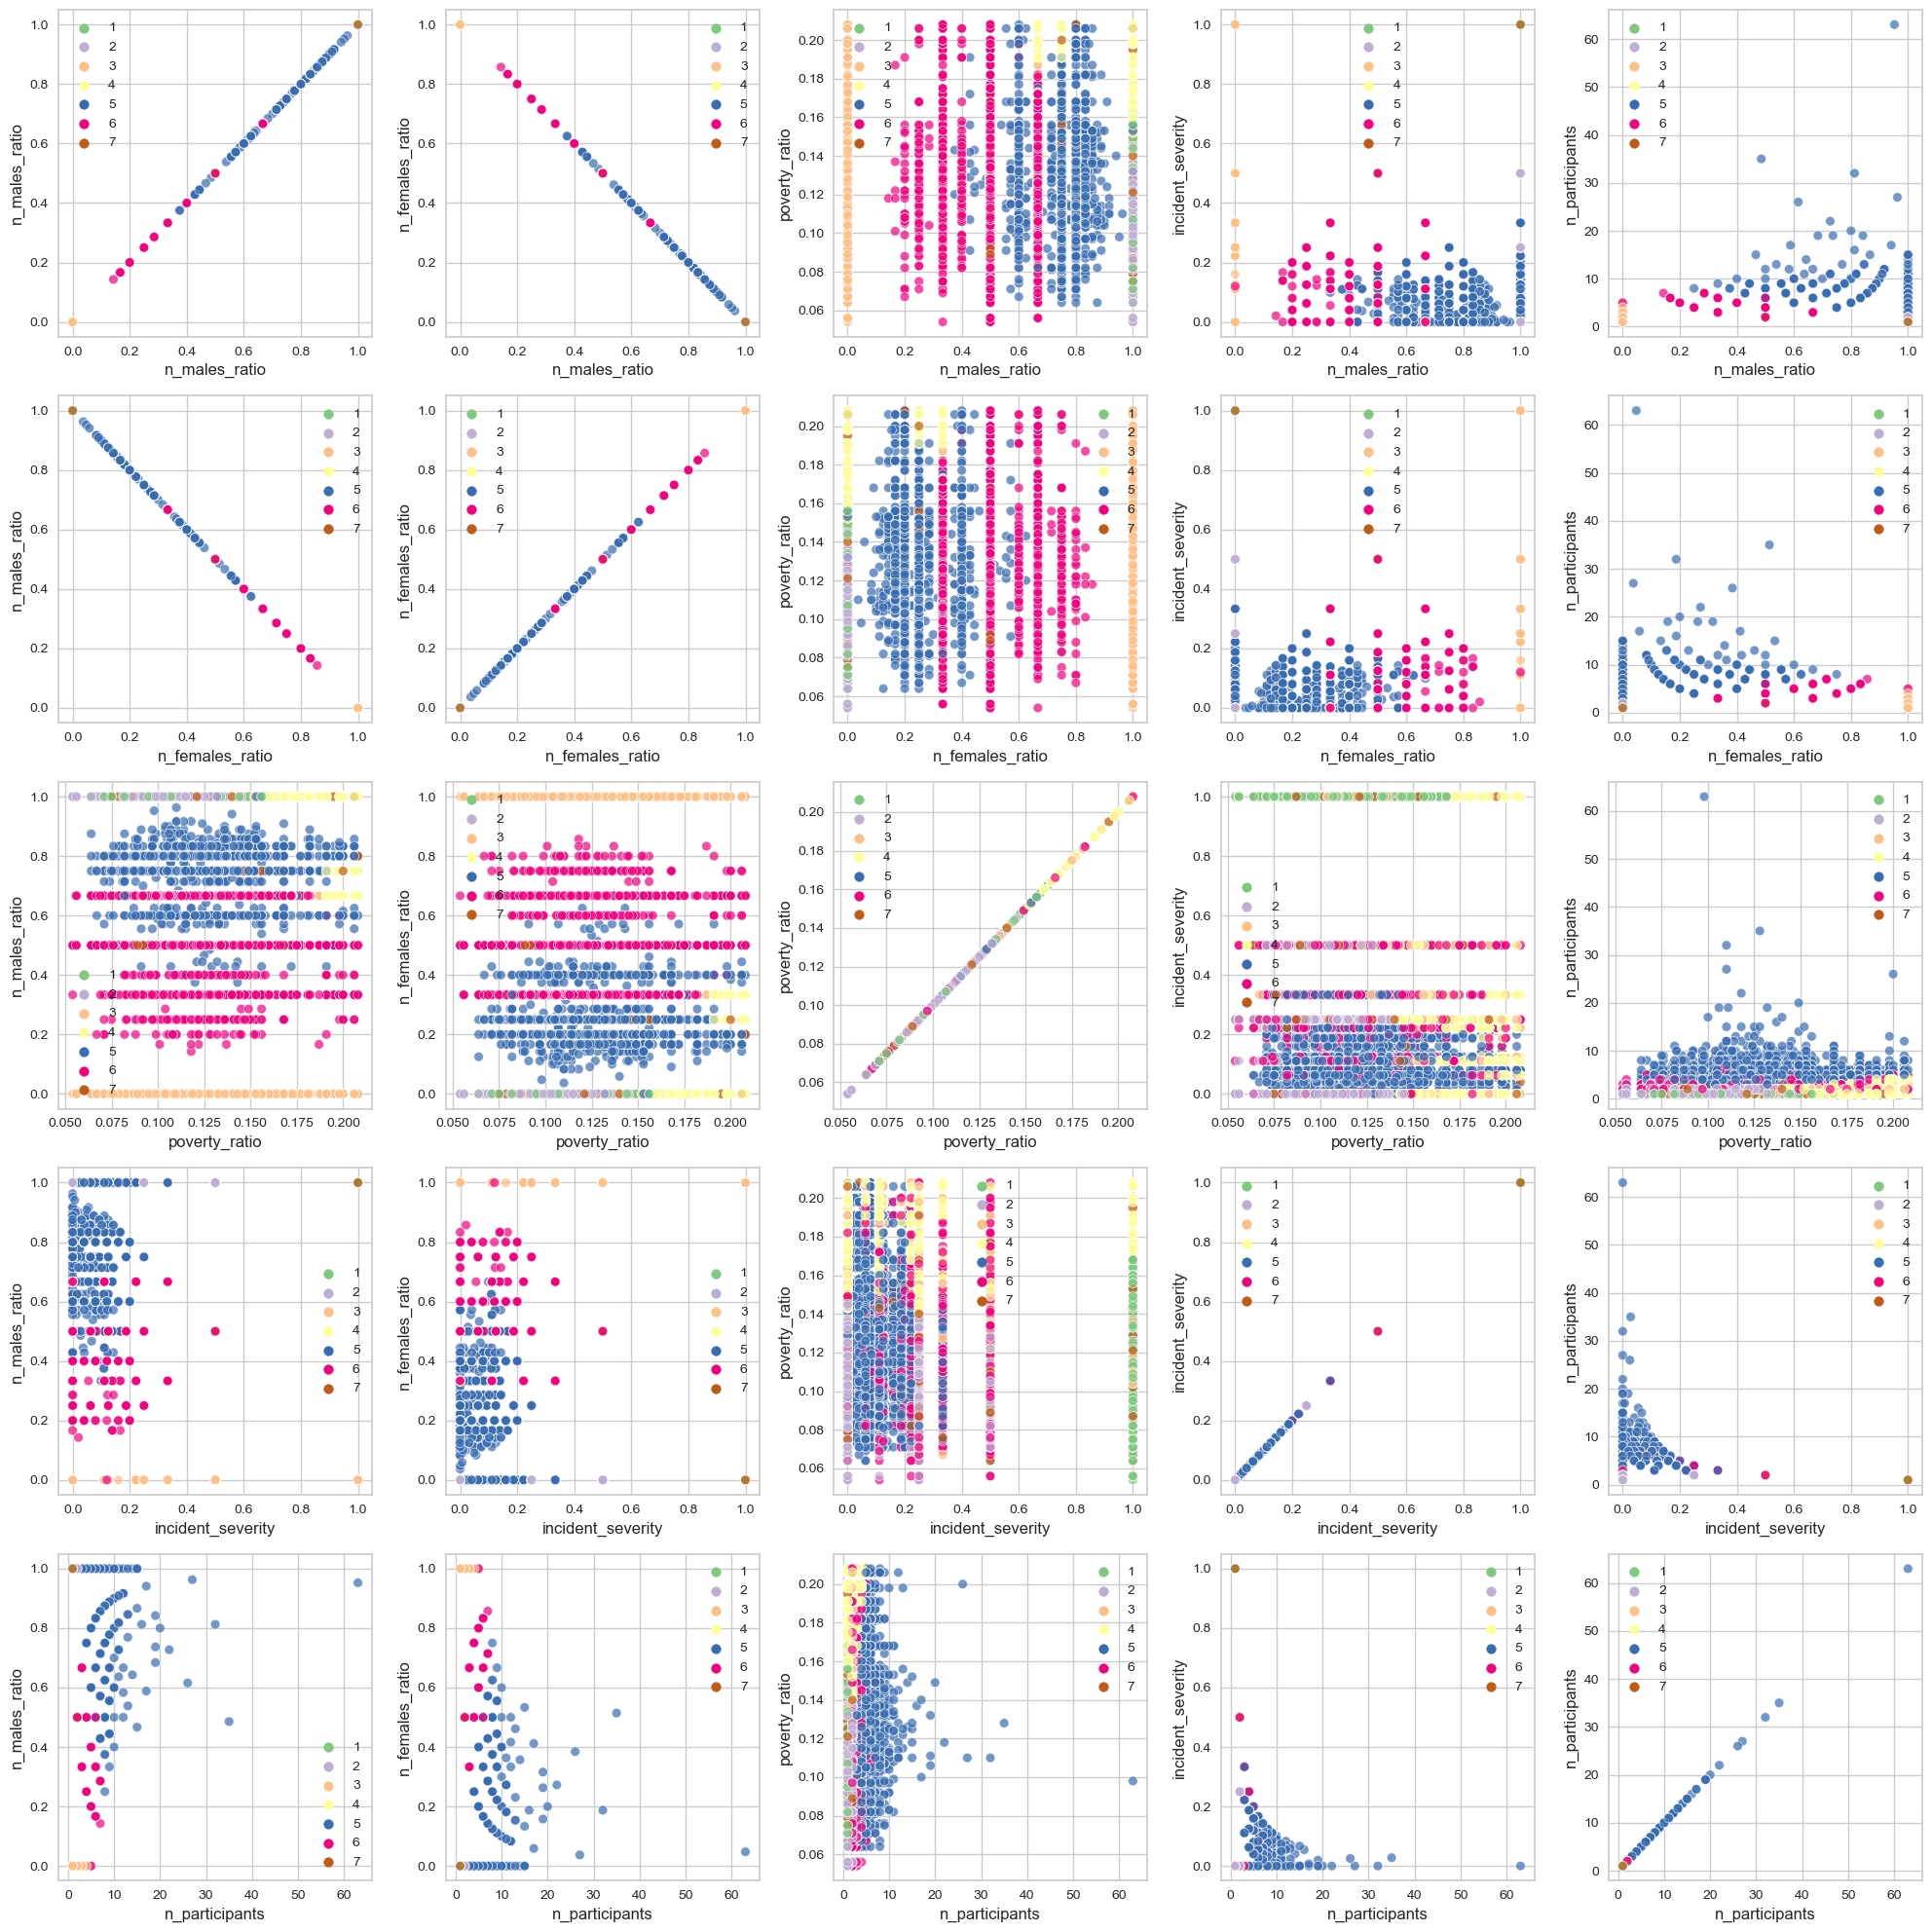

In [307]:
# Plotta i punti e i centroidi
n=len(df.columns)
fig, axs = plt.subplots(n - 1, n - 1, figsize=(20,20))

for i in np.arange(0,n-1):
    x=df.columns[i]
    for j in np.arange(0,n-1):
        y=df.columns[j]
        sns.scatterplot(x = x, y = y, data =df, hue = lbls, ax = axs[i,j], alpha=0.7,palette = "Accent")
        axs[i, j].set_xlabel(x)
        axs[i, j].set_ylabel(y)
        axs[i,j].grid(True)

plt.tight_layout()
plt.show()

Uno scatter leggermente più espressivo degli altri potrebbe essere n_males_ratio su n_participants, i clusters sembra non presentino **globular-shapes**, perciò come ci aspettavamo anche dagli score ottenuti, kmeans potrebbe non essere efficace sul dataset.

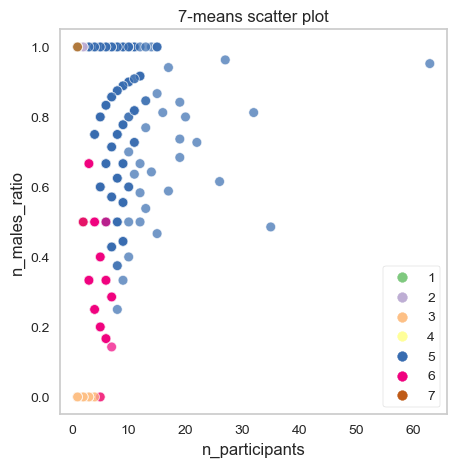

In [308]:
fig, axs = plt.subplots(figsize=(5,5))
kmeans_scatter=df.copy()
kmeans_scatter["Cluster"]=lbls
axs.grid(False)
sns.scatterplot(x = "n_participants", y = "n_males_ratio", data = df, hue = kmeans_scatter["Cluster"], palette = "Accent", ax = axs, alpha=0.7)
axs.set_ylabel("n_males_ratio")
axs.set_xlabel("n_participants")
axs.set_title("7-means scatter plot")
plt.legend(frameon=True,framealpha=1)

plt.show()

Come si vede dal grafico, tutti i punti del cluster 3 sono incidenti con solo donne coinvolte

## Hierarchical clustering

Il clustering è stato valutato secondo quando scritto in questo paper: Recommendations for validating hierarchical clustering in consumer sensory projects

- Min / Single-linkage
    - it tends to perform similarly to DBSCAN
    - is able to recognize non-elliptical clusters
    - is notoriously sensitive to noise and outliers
- Max / Complete-Linkage
    - it is more resistant than the single-linkage to outliers and noise
    - is known for breaking the larger clusters into smaller globular ones 
- Average-linkage
    - it is less susceptible to noise and outliers
    - it tends to prefer globular clusters
- Ward-linkage
    - the hierarchical analogue of K-means 
    - it is a centroid based approach with a particular interest in the minimization of the SSE values associated with each cluster

In [194]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering

methods = ['complete', 'single', 'average', 'ward']

**Calcoliamo il cophenetic coefficients per determinare il miglior metodo di clustering gerarchico**

- Uno dei motivi per cui l'avarage link performa meglio degli altri potrebbe attribursi al fatto che è meno sensibili agli outliers (Ricordiamo che gli outliers NON sono stati rimossi)

In [195]:

def get_cophenetic_coefficients(X, methods = methods) -> pd.DataFrame:
    """ 
    Calcola i coefficienti cophenetic per i vari metodi di clustering.
    """
    cophenetic_coefficients_df = pd.DataFrame()

    for method in methods:
        Z = linkage(X, method)
        cophenetic_coefficients, _ = cophenet(Z, pdist(X, metric='euclidean'))
        
        cophenetic_coefficients_df[method] = [cophenetic_coefficients]
    
    return cophenetic_coefficients_df

get_cophenetic_coefficients(df_normIllinois)

complete    single   average      ward
0  0.636865  0.704815  0.897006  0.678751

Il miglior metodo sembra essere **average linkage**

**Ploting dendrogram**

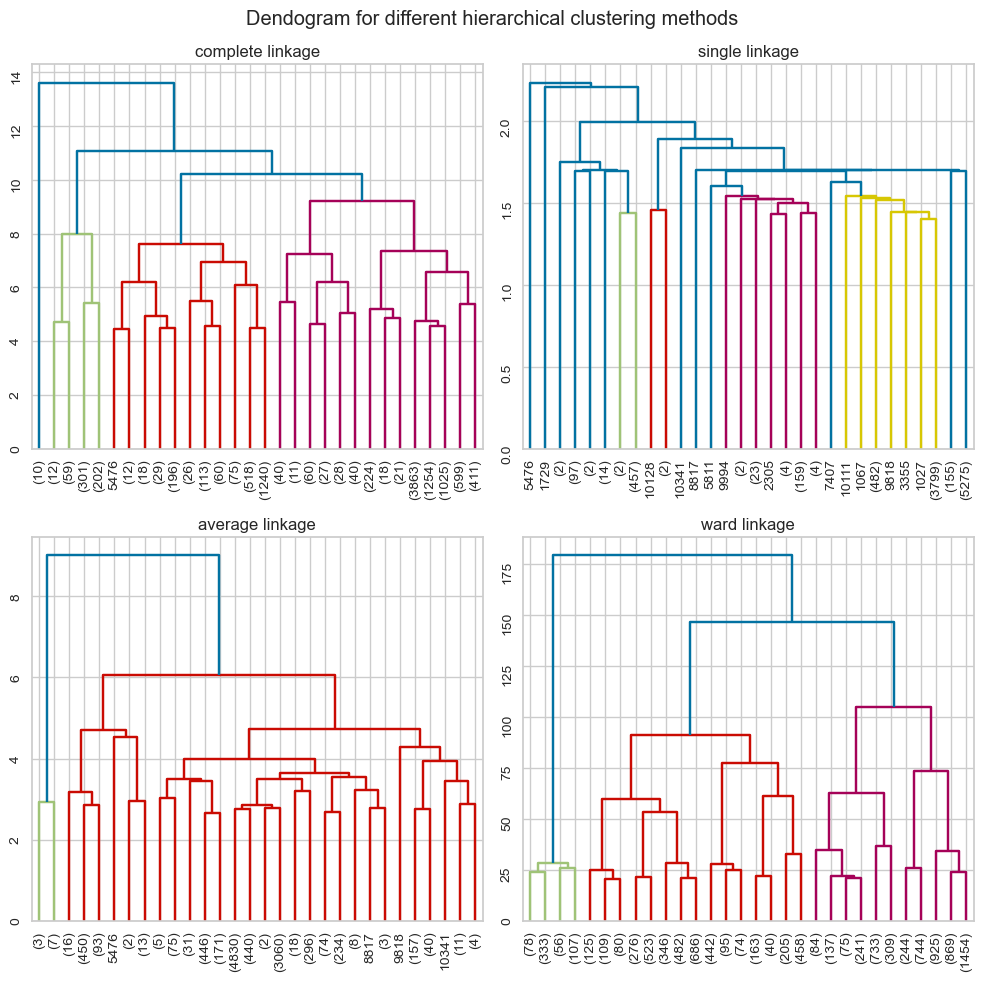

In [205]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for ax, method in zip(axs.flatten(), methods):
    data_dist = pdist(df_normIllinois, metric='euclidean')
    data_link = linkage(data_dist, method=method, metric='euclidean')
    res = dendrogram(data_link, truncate_mode='lastp', ax=ax)
    ax.set_title(f'{method} linkage')
    ax.tick_params(labelrotation = 90)

fig.suptitle("Dendogram for different hierarchical clustering methods")
plt.tight_layout()
plt.show()

**Qual è il miglior valore di k?**
- Calcoliamo silhouette score con avarage linkage per trovare il miglior taglio
- Dalla seguenti celle, si può osservare che il miglior valore di k è 2, con average linkage.

In [207]:
def _select_K(X, max_num_cluster, linkage) -> pd.DataFrame:
    """
    Calcola il clustering gerarchico per un numero di cluster che va da 2 a max_num_cluster.
    """
    
    hierarchical_clustering = pd.DataFrame()

    for n_clusters in range(2, max_num_cluster):
        resultClustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage=linkage).fit_predict(X)
        hierarchical_clustering[n_clusters] = resultClustering
    
    return hierarchical_clustering

def select_K(max_num_cluster = 20+1, methods = methods) -> dict:
    select_K_method = {}
    for method in methods:
        result = _select_K(df_normIllinois, 20+1, method)
        select_K_method[method] = result
    
    return select_K_method

select_K_method = select_K()

In [208]:
from sklearn.metrics import silhouette_score

def print_silhouette_score(best_X, select_K_method, methods):

    for method in methods:
        print(f"========Method: {method}========")
        clustering = select_K_method[method]
        for num_clusters in clustering.columns:
            score = silhouette_score(best_X, clustering[num_clusters])
            print(f"Silhouette Score per {num_clusters}: {score}")
            
print_silhouette_score(df_normIllinois, select_K_method, methods)

========Method: complete========
Silhouette Score per 2: 0.6534736988585957
Silhouette Score per 3: 0.546669689695901
Silhouette Score per 4: 0.20774773723062565
Silhouette Score per 5: 0.21724877761639796
Silhouette Score per 6: 0.2047209714472223
Silhouette Score per 7: 0.16976417624145645
Silhouette Score per 8: 0.1812486238323821
Silhouette Score per 9: 0.17342365353544456
Silhouette Score per 10: 0.15345455065604352
Silhouette Score per 11: 0.2085658389212038
Silhouette Score per 12: 0.20600103819863227
Silhouette Score per 13: 0.20404811187373376
Silhouette Score per 14: 0.19713656343053282
Silhouette Score per 15: 0.19403536832017218
Silhouette Score per 16: 0.19391843281751353
Silhouette Score per 17: 0.18036754310481032
Silhouette Score per 18: 0.18605206087979995
Silhouette Score per 19: 0.18618805860800583
Silhouette Score per 20: 0.18454828648815333
========Method: single========
Silhouette Score per 2: 0.5585020229154801
Silhouette Score per 3: 0.52043118615277
Silhouette 

**Stability analysis**:
Ha senso fare questa analisi dato che lo score è uscito abbastanza buono.
- Si generano casualmente 100 campioni all’interno del range dei valori di df_normIllinois.
- Si applica il Clustering Agglomerativo con i parametri n_clusters=2, metric='euclidean', linkage="average" sui dati generati casualmente.
- Si calcola il punteggio Silhouette sul clustering ottenuto dal punto precedente.
- Si confronta la distribuzione dei punteggi Silhouette ottenuti dai diversi dati generati casualmente con quella di df_normIllinois. Se il punteggio Silhouette di df_normIllinois risulta essere il più frequente, potrebbe indicare che il punteggio Silhouette di df_normIllinois non è affidabile. In altre parole, il Silhouette score di df_normIllinois sarebbe del tutto casuale.

Come si può osservare dalla distribuzione, lo score di 0.65 è altamente improbabile => il clustering scelto potrebbe rappresentare correttamente il dataset

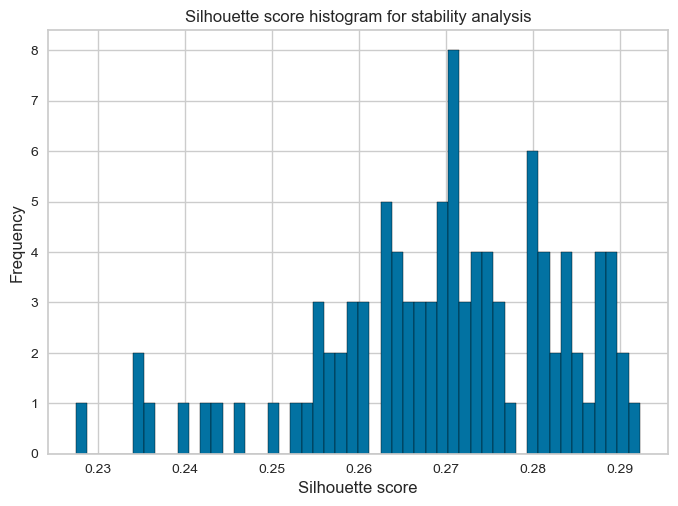

In [437]:
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

def stabilty_analysis(number_sample: int = 100, best_X = df_normIllinois, n_clusters = 2, linkage = 'average') -> None:
    """
    Best_X: dataset da cui eseguire il clustering
    """

    silhouette_scores = []
    min_values = np.min(best_X, axis=0)
    max_values = np.max(best_X, axis=0)

    # Esegui il clustering gerarchico 100 volte su dati generati casualmente nel rage di Best_X
    for _ in range(number_sample):
        # Genera dati casuali nel range di X
        X = np.random.uniform(low=min_values, high=max_values, size=best_X.shape)

        # Crea un modello di clustering gerarchico
        model = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage="average").fit(X)
        score = silhouette_score(X, model.labels_)
        silhouette_scores.append(score)
        
    return silhouette_scores


silhouette_scores = stabilty_analysis()
# Crea un istogramma dei punteggi Silhouette
plt.hist(silhouette_scores, bins=50, edgecolor='black')
plt.title('Silhouette score histogram for stability analysis')
plt.xlabel('Silhouette score')
plt.ylabel('Frequency')
plt.show()

### Interpretazione risultati
Dai vari plot si può osservare che il clustering divide gli incidenti in baso al fatto che ci siano solo bambini coinvolti

In [317]:
best_method = 'average'
best_num_clusters = 2
model = AgglomerativeClustering(n_clusters=best_num_clusters, metric='euclidean', linkage=best_method)
resultClustering = model.fit_predict(df_normIllinois)
df_illinois['cluster'] = resultClustering +1

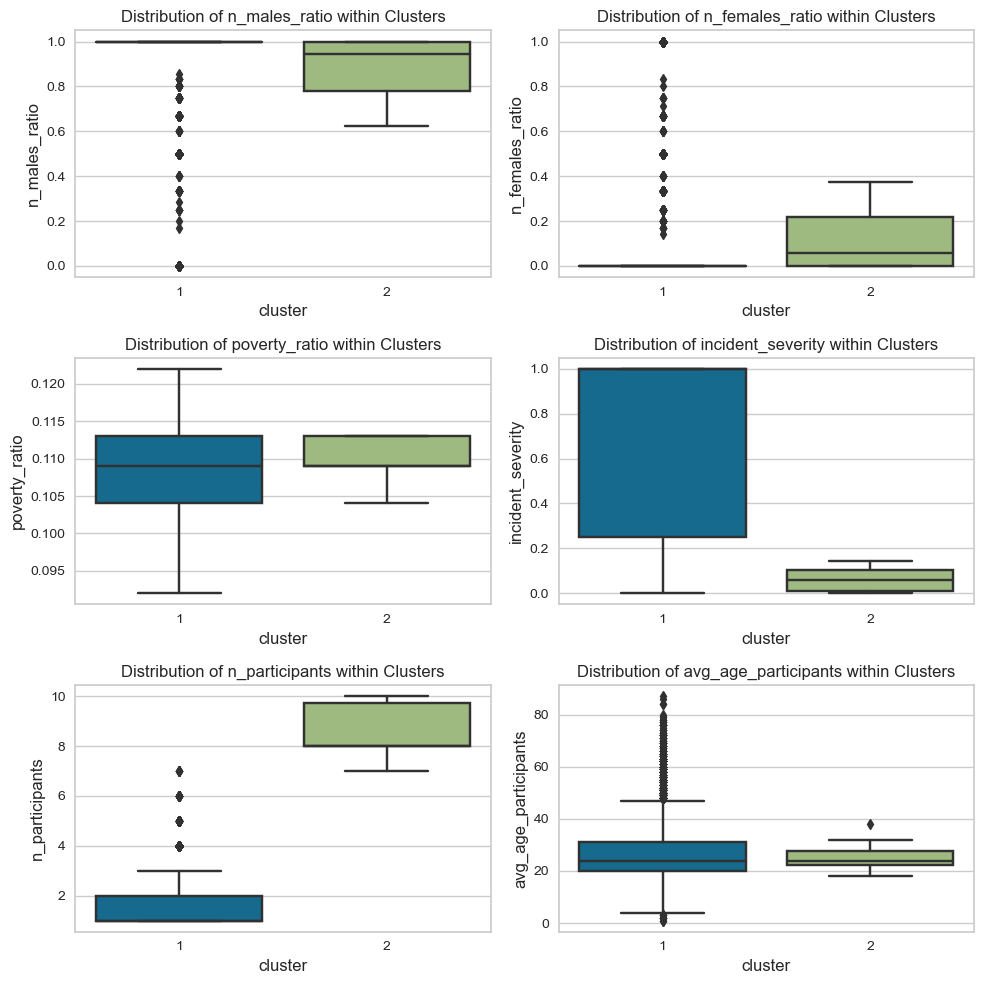

In [319]:
import matplotlib.pyplot as plt
import seaborn as sns

data = df_illinois

# Calcola il numero di righe e colonne necessarie per la griglia di grafici
n = len(data.columns) - 1
ncols = int(n**0.5)
nrows = ncols if ncols**2 == n else ncols + 1

# Crea una figura e degli assi
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))

# Disegna un grafico per ogni variabile
for ax, variable in zip(axs.flatten(), data.columns[:-1]):
    sns.boxplot(x='cluster', y=variable, data=data, ax=ax)
    ax.set_title(f'Distribution of {variable} within Clusters')

# Rimuovi gli assi vuoti
for ax in axs.flatten()[n:]:
    ax.remove()

plt.tight_layout()
plt.show()


Nel prossimo plot utilizziamo Fdf_illinois perchè usando df_illinois non avremmo un risultato molto espressivo a causa del fatto che le versioni **ratio** delle features hanno come massimo valore 1 e stiamo plottando nello stesso grafico **n_participants** che ha valori molto maggiori.

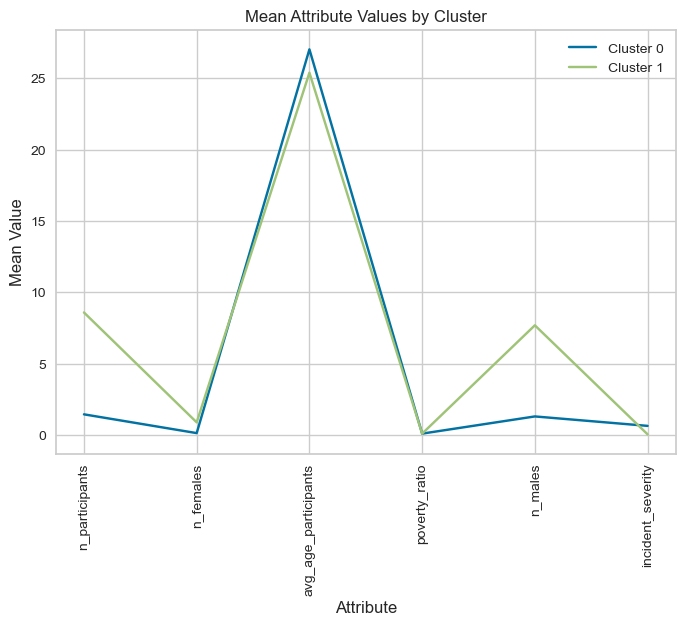

In [320]:
import matplotlib.pyplot as plt

# Calcola la media di ciascun attributo per cluster
means = Fdf_illinois.groupby('cluster').mean()

# Crea un grafico a linee per ciascun cluster
for cluster in means.index:
    plt.plot(means.columns, means.loc[cluster], label=f'Cluster {cluster}')

plt.xlabel('Attribute')
plt.ylabel('Mean Value')
plt.title('Mean Attribute Values by Cluster')
plt.legend()
plt.xticks(rotation=90)  # Ruota le etichette dell'asse x per una migliore leggibilità
plt.show()


### davies_bouldin_score per il confronto finale

In [321]:
sil= silhouette_score(df_normIllinois, model.labels_)
dav= davies_bouldin_score(df_normIllinois, model.labels_)
print(f"K = 2, silhouette_score = {sil}, davies_bouldin_score = {dav}")

K = 2, silhouette_score = 0.6534736988585957, davies_bouldin_score = 0.42582152004706403


### Scatter

In [322]:
np.arange(0,6)

array([0, 1, 2, 3, 4, 5])

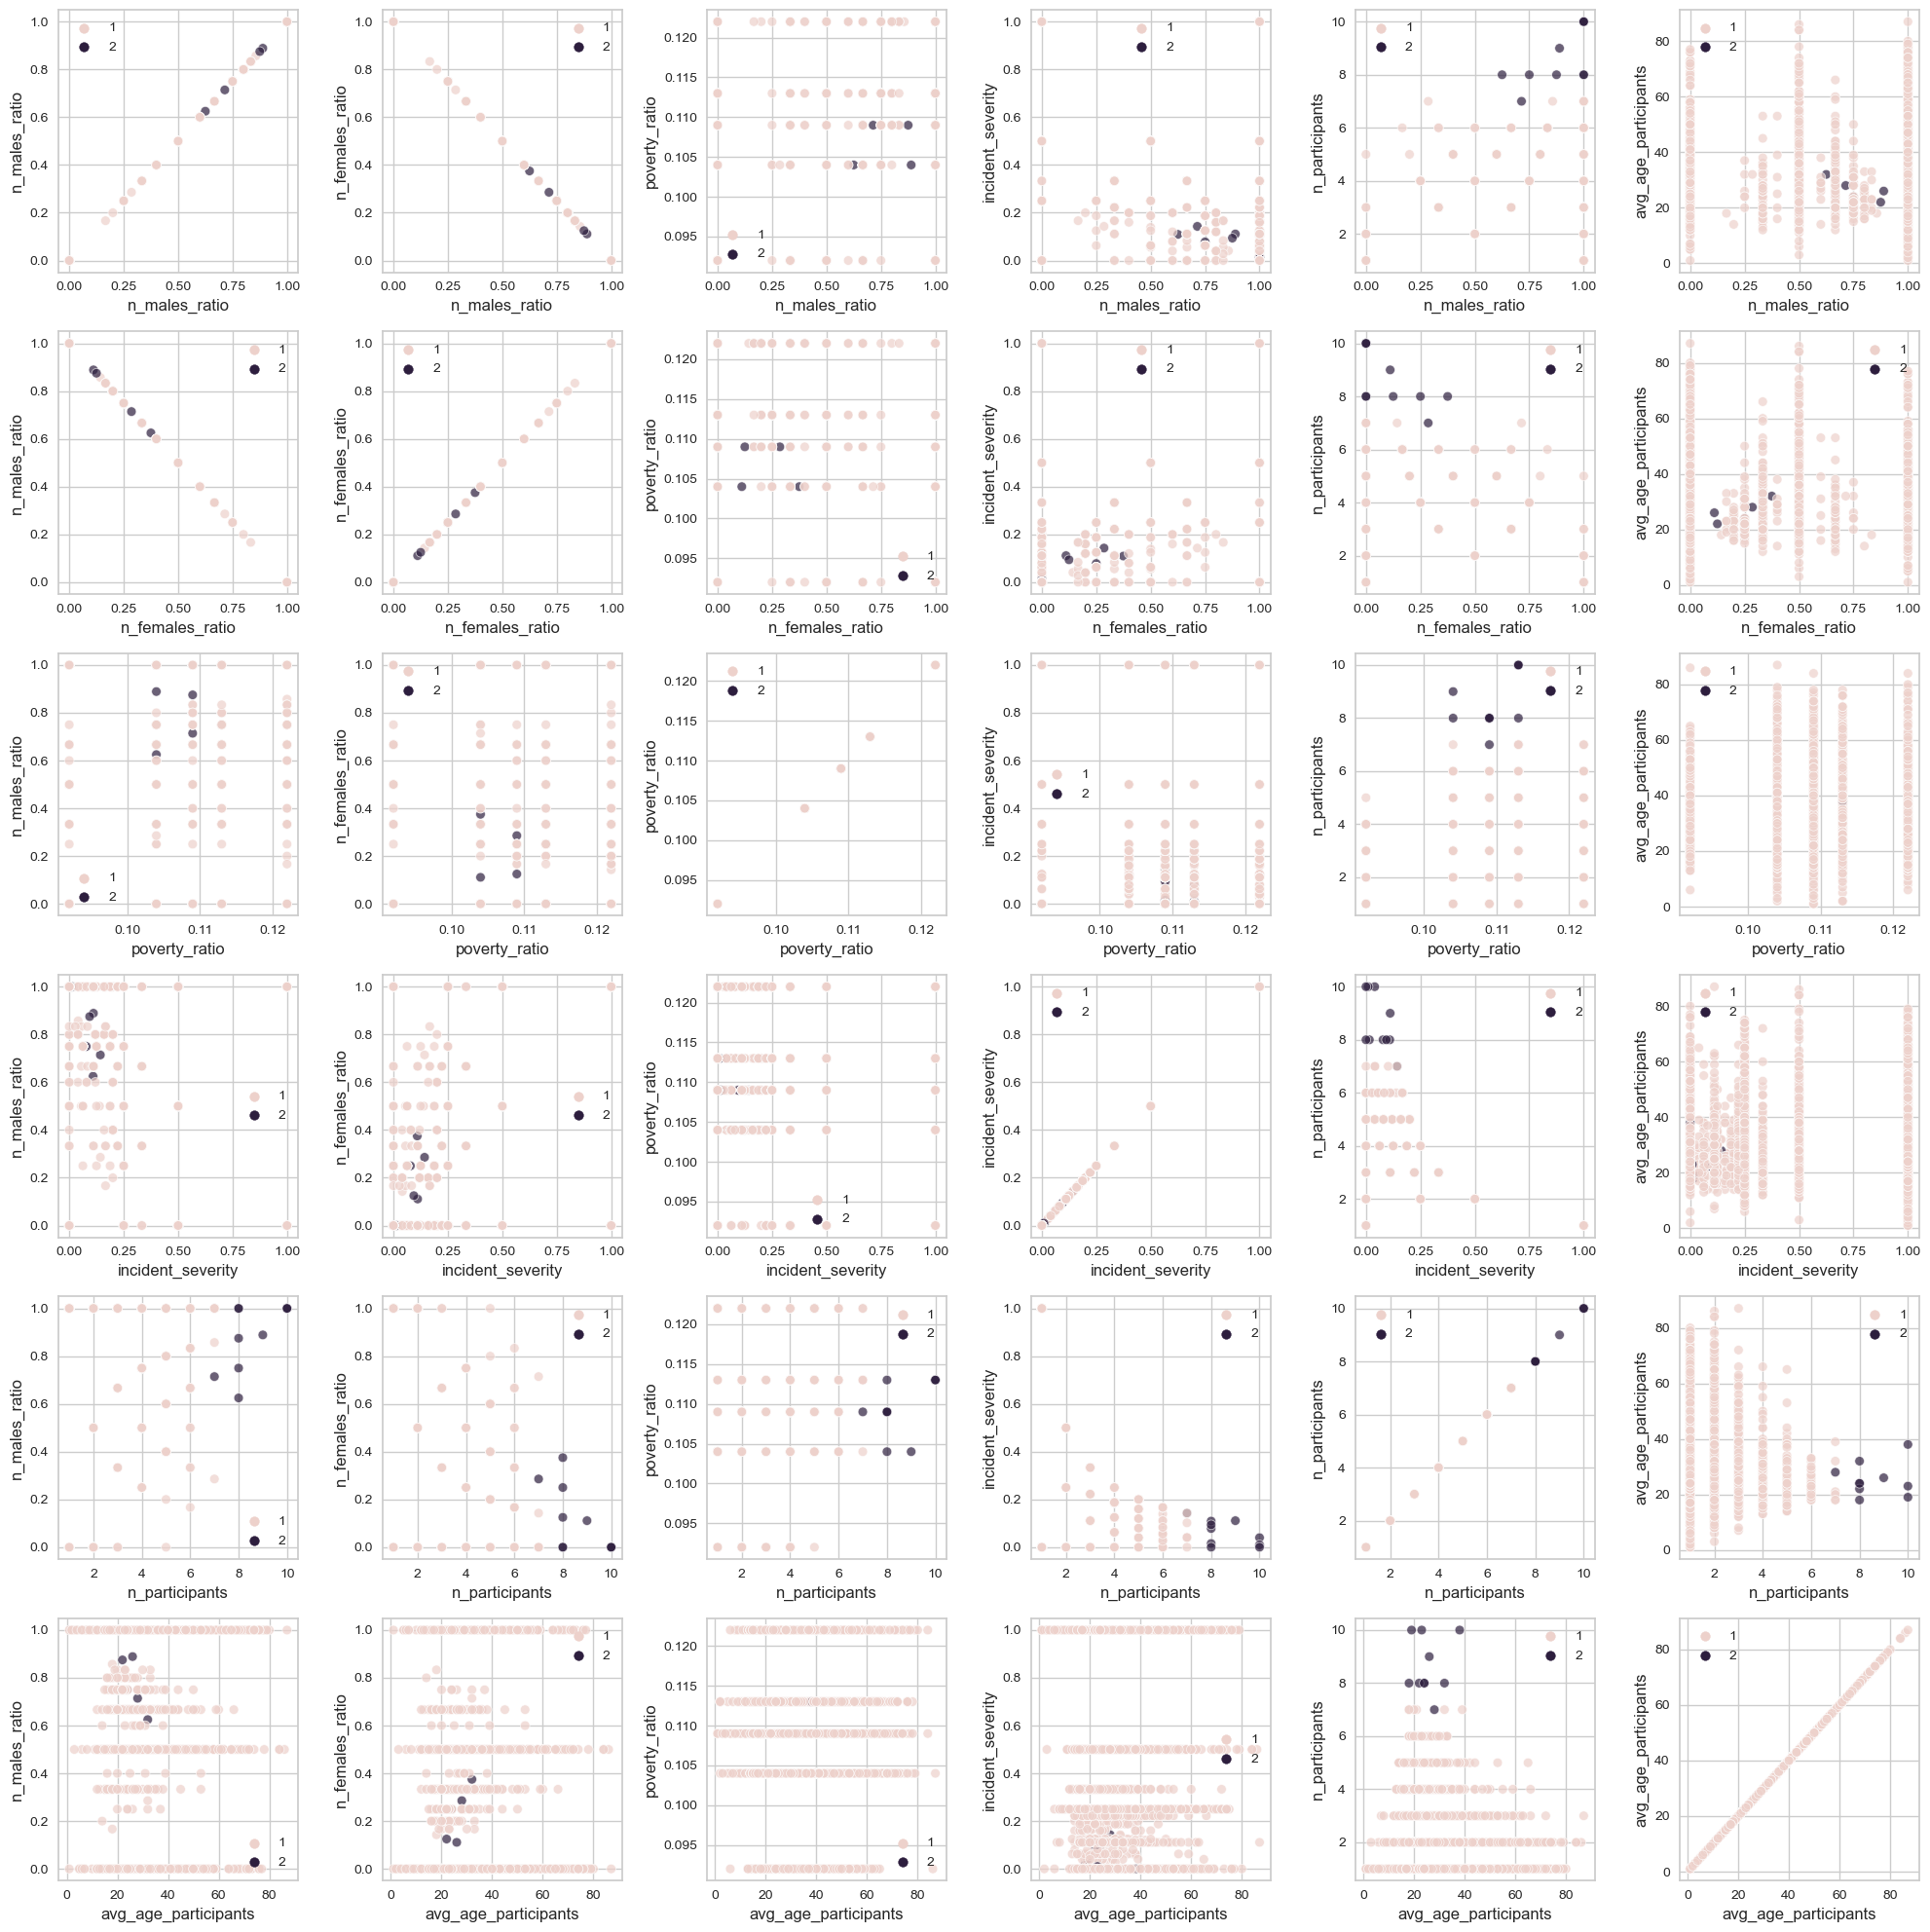

In [323]:
# Plotta i punti e i centroidi
n=len(df_illinois.columns)
lab=model.labels_+1
fig, axs = plt.subplots(n - 1, n - 1, figsize=(20,20))

for i in np.arange(0,n-1):
    x=df_illinois.columns[i]
    for j in np.arange(0,n-1):
        y=df_illinois.columns[j]
        sns.scatterplot(x = x, y = y, data = df_illinois, hue = lab, ax = axs[i,j], alpha=0.7)
        axs[i, j].set_xlabel(x)
        axs[i, j].set_ylabel(y)
        axs[i,j].grid(True)
    
plt.tight_layout()
plt.show()

Dagli scatter, in particolare quelli per avg_age_participants e n_participants sembrerebbe che il cluster 2 caratterizzi gli incidenti con maggior numero di partecipanti, che sono anche quelli con età media compresa tra i 20 e i 40 anni

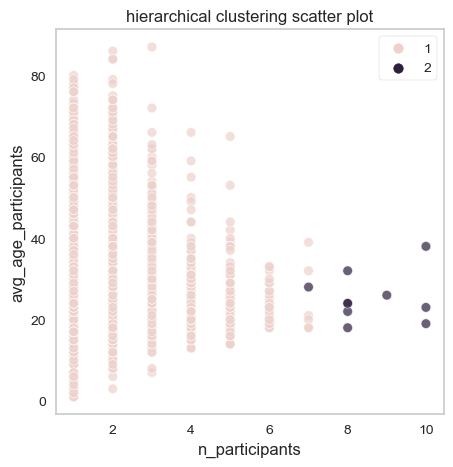

In [324]:
fig, axs = plt.subplots(figsize=(5,5))
axs.grid(False)
sns.scatterplot(x = "n_participants", y ="avg_age_participants", data = df_illinois, hue = lab, ax = axs, alpha=0.7)
axs.set_ylabel("avg_age_participants")
axs.set_xlabel("n_participants")
axs.set_title("hierarchical clustering scatter plot")
plt.legend(frameon=True,framealpha=1)

plt.show()


## Density-based Clustering

iniziamo applicando DBSCAN allo stesso data set della sezione precedete.<br>
Per la scelta di minpts si opta per **10 * n**, dove n è la dimensionalità della tabella.
La scelta di minpts è dovuta alla grande mole di dati rumorosi (sono stati provati altri valori più piccoli ma senza grandi risultati)
Per prima cosa si stima con Silhouette score per minPts =60, il miglior epsilon, prima con un metodo grafico, poi con brute force su un intervallo limitato.<br>
Silhouette score a causa delle varie densità ma sopratutto del tipo di gestione del noise di dbscan non è ottimale come misura. Lo score infatti non tiene conto del fatto che i punti nel cluster -1 sono noise point indipendenti gli uni dagli altri. L'algoritmo invece parte dal presupposto che tutti i punti appartengano ad un cluster, quindi in questo caso, tutti i noise points trovati da DBSCAN appartengono allo stesso clusters, alterando così il risultato dello score.<br>

In [410]:
#metodo grafico per stimare EPS
from scipy.spatial.distance import pdist, squareform
df_illinois["cluster"]=0

df_illinois=df_illinois.drop('cluster', axis=1)
def getSortedList (k,dist):
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        #ordini la riga aka la lista di distanze da uno specifico punto e prendi la distanza del k-esimo punto più vicino
        kth_distances.append(d[index_kth_distance])
    return sorted(kth_distances)

dist = pdist(df_normIllinois, 'euclidean') #pair wise distance
dist = squareform(dist) #distance matrix given the vector dist
#la matrice risultante contiene alla posizione v_a,b la distanza euclidea tra il punto a e b.
sorted_60=getSortedList(60,dist)
sorted_7 = getSortedList(7,dist)

(min_points=60) -> EPS = 2.001448968029316


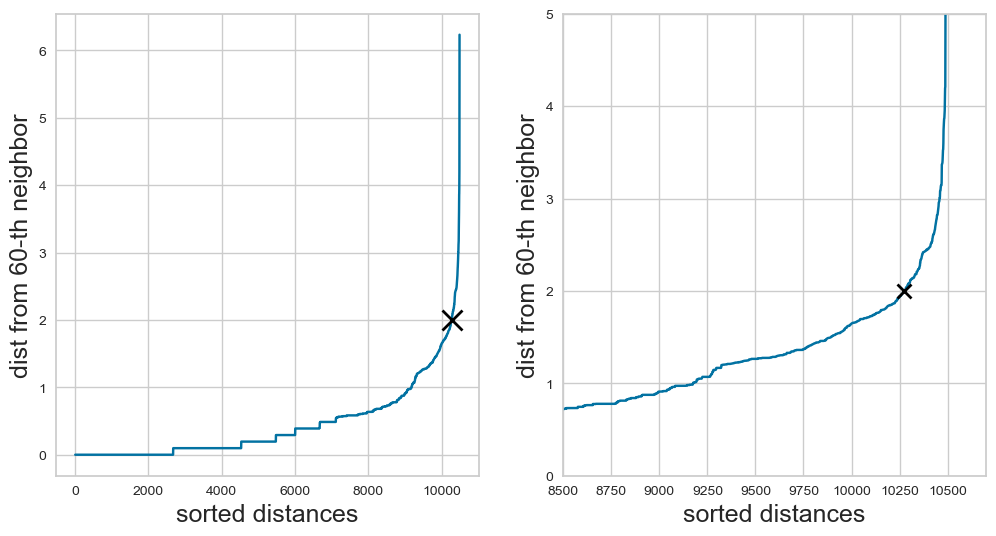

In [433]:
# troviamo il miglior valore di eps
fig,(ax,ax2)= plt.subplots(ncols=2,nrows=1,figsize=(12,6))

ax.plot(range(0, len(sorted_60)), sorted_60)
ax.set_ylabel('dist from 60-th neighbor', fontsize=18)
ax.set_xlabel('sorted distances', fontsize=18)
ax.plot(10275,sorted_60[10275],marker="x",c="black",ms=15,mew=2)

ax2.plot(range(0, len(sorted_60)), sorted_60)
ax2.set_ylabel('dist from 60-th neighbor', fontsize=18)
ax2.set_xlabel('sorted distances', fontsize=18)
ax2.set_ylim(0,5)
ax2.set_xlim(8500,10700)
ax2.plot(10275,sorted_60[10275],marker="x",c="black",ms=10,mew=2)


print("(min_points=60) -> EPS = "+ str(sorted_60[10275]))

Dopo aver svolto molte prove, si calcolano gli score con **eps = 2** per valori di **min samples** da 7 (n+1, rule of thumb) a 60 (10*n, usata nel caso di dati molto sporchi)

In [427]:
from sklearn.cluster import DBSCAN

def print_score(epsList, min_samples_):
    for eps in epsList:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples_)
        dbscan.fit(df_normIllinois)
        np.unique(dbscan.labels_, return_counts=True)
        clusters=len(np.unique(dbscan.labels_))
        print('minsample = %s, eps= %s => K= %s, Silhouette %s, davies-bouldin %s' %(min_samples_,eps,clusters,silhouette_score(df_normIllinois, dbscan.labels_),davies_bouldin_score(df_normIllinois, dbscan.labels_)))

eps1 = 2

epsList= [eps1]

for i in range(7,61):
    print_score(epsList,i)


minsample = 7, eps= 2 => K= 2, Silhouette 0.6199617492219875, davies-bouldin 1.3072325776234495
minsample = 8, eps= 2 => K= 2, Silhouette 0.6199617492219875, davies-bouldin 1.3072325776234495
minsample = 9, eps= 2 => K= 2, Silhouette 0.655399827468165, davies-bouldin 1.2314014179733137
minsample = 10, eps= 2 => K= 2, Silhouette 0.655399827468165, davies-bouldin 1.2314014179733137
minsample = 11, eps= 2 => K= 2, Silhouette 0.6577521424430725, davies-bouldin 1.1297318815875181
minsample = 12, eps= 2 => K= 2, Silhouette 0.6577521424430725, davies-bouldin 1.1297318815875181
minsample = 13, eps= 2 => K= 2, Silhouette 0.6501911505026194, davies-bouldin 1.292051104747509
minsample = 14, eps= 2 => K= 2, Silhouette 0.6424279134923576, davies-bouldin 1.1708014989383162
minsample = 15, eps= 2 => K= 2, Silhouette 0.6424279134923576, davies-bouldin 1.1708014989383162
minsample = 16, eps= 2 => K= 2, Silhouette 0.6424279134923576, davies-bouldin 1.1708014989383162
minsample = 17, eps= 2 => K= 2, Silh

### Result: 
Le coppie di valori migliori sono:<br>
1. minsample = 22, eps= 2 => K= 2, Silhouette 0.6393932506746319, davies-bouldin 1.1053066377688172 implica che sia stato effettivamente individuato solo un cluster oltre quello di noise points, quindi si scarta
2. minsample = 30, eps= 2 => K= 3, Silhouette 0.5478870468351259, davies-bouldin 0.8895626845936647 risulta essere il miglior risultato
<br>Si prova infine a trovare un valore migliore per eps nell'intervallo [1, 2] con min samples = 30 

In [436]:
for eps_ in np.arange(0.1,2.1,0.1):    
    dbscan = DBSCAN(eps=eps_, min_samples=30)
    dbscan.fit(df_normIllinois)
    np.unique(dbscan.labels_, return_counts=True)
    clusters=len(np.unique(dbscan.labels_))
    print('minsample = %s, eps= %s => K= %s, Silhouette %s, davies-bouldin %s' %(30,eps_,clusters,silhouette_score(df_normIllinois, dbscan.labels_),davies_bouldin_score(df_normIllinois, dbscan.labels_)))

minsample = 30, eps= 0.1 => K= 27, Silhouette 0.04283314737456174, davies-bouldin 1.6431475032695924
minsample = 30, eps= 0.2 => K= 25, Silhouette 0.09229173409467414, davies-bouldin 1.3760207297119762
minsample = 30, eps= 0.30000000000000004 => K= 29, Silhouette 0.14208125729870197, davies-bouldin 1.4824828490673834
minsample = 30, eps= 0.4 => K= 31, Silhouette 0.16211463727405795, davies-bouldin 1.5171750918041613
minsample = 30, eps= 0.5 => K= 31, Silhouette 0.17487721509423443, davies-bouldin 1.6529256718025591
minsample = 30, eps= 0.6 => K= 30, Silhouette 0.22301241860935048, davies-bouldin 1.7041153142157053
minsample = 30, eps= 0.7000000000000001 => K= 24, Silhouette 0.2699438401901375, davies-bouldin 1.6097817692422296
minsample = 30, eps= 0.8 => K= 19, Silhouette 0.33820361425422046, davies-bouldin 1.5078077509585834
minsample = 30, eps= 0.9 => K= 19, Silhouette 0.3398678587017163, davies-bouldin 1.5919040587820914
minsample = 30, eps= 1.0 => K= 20, Silhouette 0.34194552586328

Il risultato migliore rimane per **eps = 2**

In [438]:
dbscan = DBSCAN(eps=2, min_samples=30)
dbscan.fit(df_normIllinois)
np.unique(dbscan.labels_, return_counts=True)
clusters=len(np.unique(dbscan.labels_))

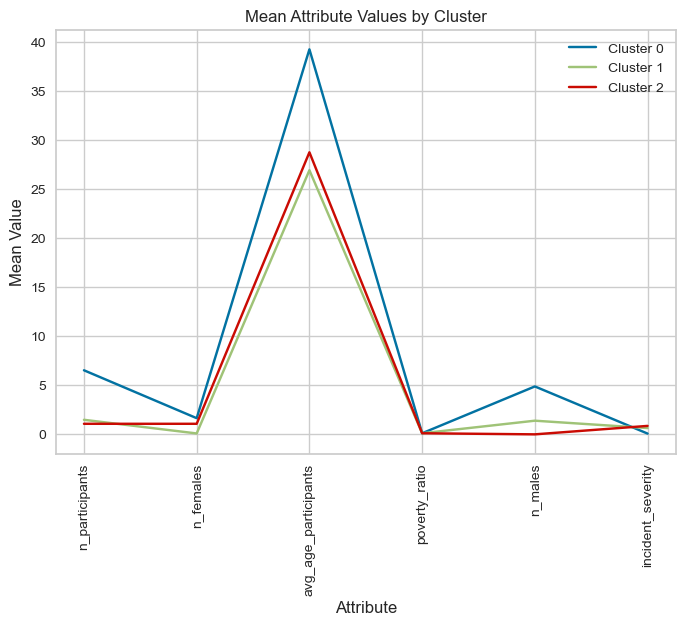

In [444]:
Fdf_illinois["cluster"] = dbscan.labels_ +1
means = Fdf_illinois.groupby('cluster').mean()

# Crea un grafico a linee per ciascun cluster
for cluster in means.index:
    plt.plot(means.columns, means.loc[cluster], label=f'Cluster {cluster}')

plt.xlabel('Attribute')
plt.ylabel('Mean Value')
plt.title('Mean Attribute Values by Cluster')
plt.legend()
plt.xticks(rotation=90)  # Ruota le etichette dell'asse x per una migliore leggibilità
plt.show()

Si ricorda che il cluster **0** è quello dei noise data, inoltre un risultato significativo si ha per il cluster **2** che non contiene nessun incidente con uomini tra i partecipanti registrati

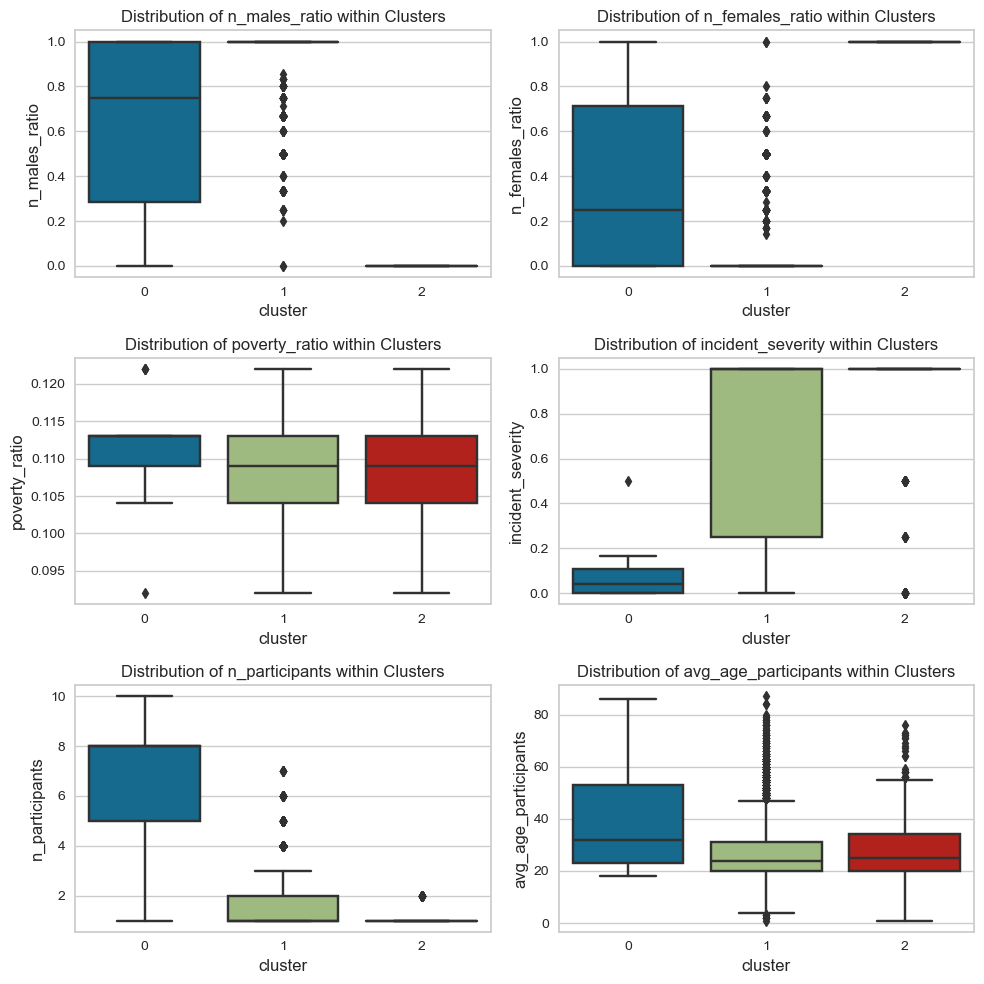

In [448]:
df_illinois["cluster"] = dbscan.labels_ +1
data = df_illinois

# Calcola il numero di righe e colonne necessarie per la griglia di grafici
n = len(data.columns) - 1
ncols = int(n**0.5)
nrows = ncols if ncols**2 == n else ncols + 1

# Crea una figura e degli assi
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))

# Disegna un grafico per ogni variabile
for ax, variable in zip(axs.flatten(), data.columns[:-1]):
    sns.boxplot(x='cluster', y=variable, data=data, ax=ax)
    ax.set_title(f'Distribution of {variable} within Clusters')

# Rimuovi gli assi vuoti
for ax in axs.flatten()[n:]:
    ax.remove()

plt.tight_layout()
plt.show()

### Scatter plot

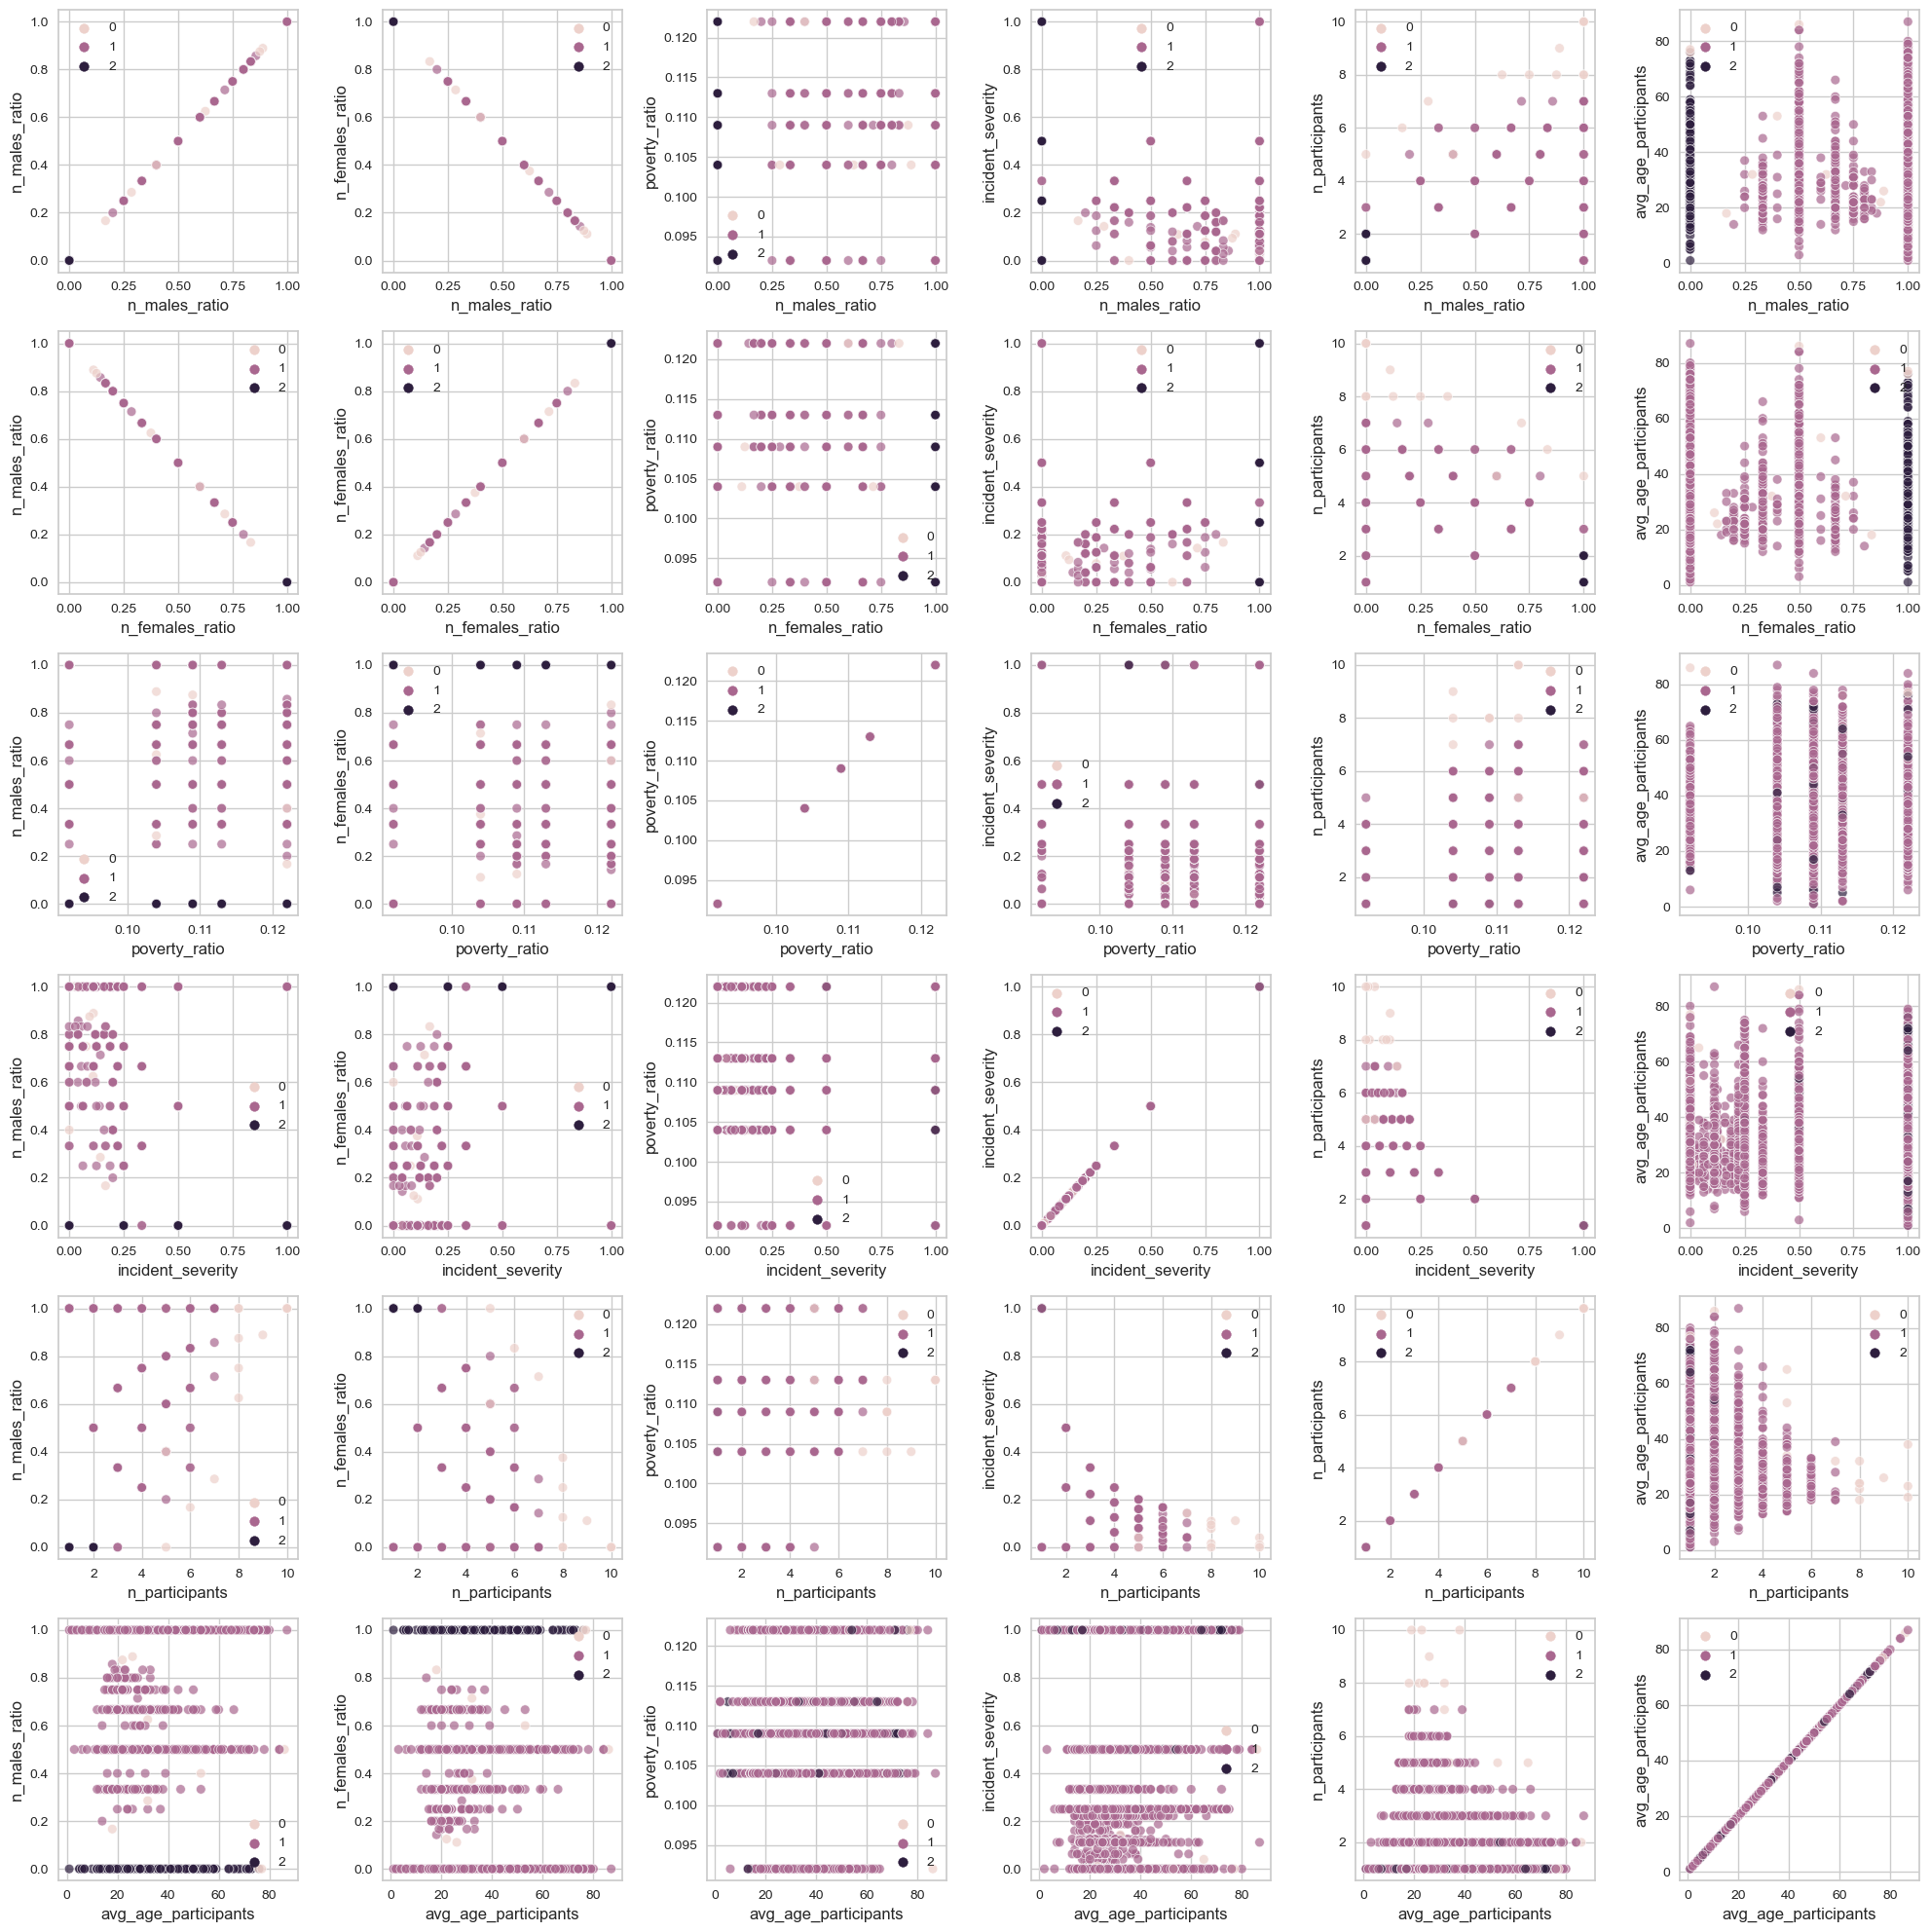

In [449]:
# Plotta i punti e i centroidi
n=len(df_illinois.columns)
lab=dbscan.labels_+1
fig, axs = plt.subplots(n - 1, n - 1, figsize=(20,20))

for i in np.arange(0,n-1):
    x=df_illinois.columns[i]
    for j in np.arange(0,n-1):
        y=df_illinois.columns[j]
        sns.scatterplot(x = x, y = y, data = df_illinois, hue = lab, ax = axs[i,j], alpha=0.7)
        axs[i, j].set_xlabel(x)
        axs[i, j].set_ylabel(y)
        axs[i,j].grid(True)
    
plt.tight_layout()
plt.show()

Gli scatter non sono particolarmenti interessanti, possiamo però caratterizzare il cluster 2 come quello che caratterizza gli incidenti con totalità di partecipanti femminili. Il cluster 2, rispetto al cluster 1, di incidenti generici, presenta le seguenti caratteristiche:
1. Il numero di partecipanti per incidente è minore di quello del cluster 1
2. Il numero di incidenti che ne fanno parte è minore rispetto al cluster 1
3. l'attributo **incident_severity** è quasi sempre uguale ad 1 e ciò implica che quasi sempre tutte le partecipanti a seguito dell'incidente rimangono ferite o muoiono.